## Librerie e funzioni ausiliarie

In [ ]:
import math
import random
import numpy as np
import pandas as pd
from itertools import chain, combinations

############################################################################################

def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += ele  
    
    # return string  
    return str1

############################################################################################

def print_parameters(biases, weights, shape):

  print('##########################')

  for b in range(1,shape[0]+shape[1]+1):
    b = 'b{}'.format(str(b))
    print(b,'=',biases[b])

  print('--------------------------')

  for i in range(1,shape[0]+1):
    for j in range(1,shape[1]+1):
      w = 'W{}'.format(str(i)+str(shape[0]+j))
      print(w,'=',weights[w])

  print('##########################')

############################################################################################

# skeleton of all possible neuron combinations of values
def compute_all_combinations(N_neurons):
  skeleton = -1*np.ones((2**N_neurons,N_neurons))
  for i in range(len(skeleton)):
      a = [int(el) for el in list("{0:b}".format(i))]
      temp = np.pad(a,(len(skeleton[i])-len(a),0),"constant",constant_values=(0,0))
      skeleton[i] = skeleton[i] +2*temp
  skeleton = np.flip(skeleton,0)   
  return skeleton 

############################################################################################
# all possible subsets of a given set
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

############################################################################################

def compute_scalar_products(dataset):

  N_neurons = len(dataset[0])
  scalar_products = np.ones(2**N_neurons)
  partitions = [ list(el) for el in list(powerset(range(N_neurons)))]
  M = len(dataset[:,0])

  for i in range(1,2**N_neurons):
      scalar_products[i] = (np.sum([np.prod(el) for el in dataset[:,partitions[i]]]))/M

  #print(scalar_products)

  return scalar_products

############################################################################################

def compute_marginal_probabilities(N_neurons, scalar_products):

  partitions = [ list(el) for el in list(powerset(range(N_neurons)))]

  skeleton = compute_all_combinations(N_neurons)


  marginal_probabilities = np.zeros(2**N_neurons)

    
  for i in range(len(marginal_probabilities)):
      
      coef = np.zeros(len(marginal_probabilities))
      for k in range(len(partitions)):
          coef[k] = np.prod(skeleton[i][partitions[k]] )
          
      marginal_probabilities[i] = np.dot(scalar_products, coef)  
      
  marginal_probabilities = marginal_probabilities/(2**N_neurons)

  #print(marginal_probabilities)

  return marginal_probabilities

############################################################################################

def compute_hamiltonian(weights, biases, configuration):
    bias_contr = np.sum([  list(biases.values())[k] * configuration[k]  for k in range(len(configuration))   ])

    weights_list = list(boltz.weights.keys())
    weights_contr = 0
    for k in range(len(weights_list)):
      n1 = int(weights_list[0][-2])-1
      n2 = int(weights_list[0][-1])-1

      weights_contr += boltz.weights[weights_list[k]] * configuration[n1] * configuration[n2]
    #print(bias_contr)
    #print(weights_contr)
    return bias_contr + weights_contr
    
    #b1*s1 + b2*s2 + b3*s3 + W12*s1*s2 + W13*s1*s3 + W23*s2*s3 

## Creazione del dataset

In [ ]:
##############################################
############ 1+1 neurons datasets ############
##############################################

# BUFFER dataset
#dataset = np.array([  [1,1],[-1,-1]  ])

# NOT dataset
#dataset = np.array([  [-1,1],[1,-1]  ])

##############################################
############ 2+1 neurons datasets ############
##############################################

# balanced dataset
#dataset = compute_all_combinations(3)

# NAND dataset
dataset = np.array([  [1,1,-1],[1,-1,1],[-1,1,1],[-1,-1,1]  ])

# NAND dataset sbilanciato
#dataset = np.array([  [1,1,-1],[1,1,-1],[1,1,-1],[1,1,-1],[1,1,-1],[1,-1,1],[-1,1,1],[-1,-1,1]  ])

 # OR dataset
#dataset = np.array([  [1,1,1],[1,-1,1],[-1,1,1],[-1,-1,-1]  ])

 # XOR dataset
#dataset = np.array([  [1,1,-1],[1,-1,1],[-1,1,1],[-1,-1,-1]  ])

 # XOR dataset sbilanciato
#dataset = np.array([  [1,1,-1],[1,-1,1],[1,1,-1],[1,-1,1],[1,1,-1],[1,-1,1],[-1,1,1],[-1,-1,-1]  ])

 # Custom dataset
#dataset = np.array([  [1,1,-1]  ])

##############################################
############ 2+2 neurons datasets ############
##############################################

 # AND ed OR dataset 
#dataset = np.array([  [1,1,1,1],[1,-1,-1,1],[-1,1,-1,1],[-1,-1,-1,-1]  ])


############################################################################

print('Dataset:')
print(dataset)
print()

for i in range(4):
  dataset = np.vstack((dataset, dataset ))

dataset = np.vstack((compute_all_combinations(len(dataset[0])), dataset )) #adding to dataset an element for all possible combinations

#print(dataset)

Dataset:
[[ 1  1 -1]
 [ 1 -1  1]
 [-1  1  1]
 [-1 -1  1]]



## Modello: Macchina di Boltzman a 2 layer, con numero arbitrario di neuroni per layer

In [ ]:
class BoltzmannMachine:

  def __init__(self, shape):

    self.shape = shape

    self.N_neurons = np.sum(self.shape)

    self.powerset = list(powerset(list(range(self.N_neurons))))

    self.skeleton = compute_all_combinations(self.N_neurons)

    self.partitions = [ list(el) for el in list(powerset(range(self.N_neurons)))]

    self.parameters = np.zeros(2**self.N_neurons)
    self.biases = {}
    self.weights = {}

    for i in range(1, self.N_neurons+1):
        self.biases['b{}'.format(i)] = self.parameters[i]

        
    for i in range( self.N_neurons+1 , self.N_neurons + 1 + (self.N_neurons-1)*(self.N_neurons)//2 ):
        self.weights['W{}'.format(listToString([str(el +1) for el in self.partitions[i]]))] = self.parameters[i]

########################################################################################################################

  def train_on_dataset(self, dataset):

    self.scalar_products = compute_scalar_products(dataset)

    self.marginal_probabilities = compute_marginal_probabilities(self.N_neurons, self.scalar_products)

    self.biases = {}
    self.weights = {}


    self.parameters = np.zeros(2**self.N_neurons)

    self.parameters[0] = (1/2**self.N_neurons)*math.log(np.prod(self.marginal_probabilities))

    for k in range(1, len(self.parameters)):
        temp=[]
        
        temp = [self.marginal_probabilities[j]**(np.prod([self.skeleton[j][l] for l in self.powerset[k]])) for j in range(len(self.marginal_probabilities))]
        
        temp = np.prod(temp)
        self.parameters[k] = (1/2**self.N_neurons)*math.log(temp)


    for i in range(1, self.N_neurons+1):
        self.biases['b{}'.format(i)] = self.parameters[i]

        
    for i in range( self.N_neurons+1 , self.N_neurons + 1 + (self.N_neurons-1)*(self.N_neurons)//2 ):
        self.weights['W{}'.format(listToString([str(el +1) for el in self.partitions[i]]))] = self.parameters[i]

    # "cut" links between neurons of same layer
    cut = True
    if cut:
      for i in range(self.shape[0]):
        for j in range(i,self.shape[0]):
          if i != j:
            self.weights['W{}{}'.format(i+1,j+1)] = 0.0

      for i in range(self.shape[0],self.shape[0]+self.shape[1]):
        for j in range(i,self.shape[0]+self.shape[1]):
          if i != j:
            self.weights['W{}{}'.format(i+1,j+1)] = 0.0

    
########################################################################################################################

  def print_parameters(self):
    print_parameters(self.biases, self.weights, self.shape)

########################################################################################################################

  def compute_marginals(self):
    self.marginals = np.zeros(len(self.skeleton))
    for i in range(len(self.marginals)):
        self.marginals[i] = math.exp(compute_hamiltonian( self.weights,self.biases, self.skeleton[i] ))
        #self.marginals[i] = math.exp(compute_hamiltonian( self.weights,self.biases,       [1,1,1]       ))
    
    Z = np.sum(self.marginals)
    self.marginals = self.marginals/Z

########################################################################################################################

  def print_marginals(self):
    for i in range(len(self.marginals)):
      print("configuration ",self.skeleton[i]," has probability: ", round(self.marginals[i],2))
      print()

########################################################################################################################

  def compute_neuron_probs(self):
    self.neuron_probs = np.zeros(boltz.N_neurons)
    for neuron in range(self.N_neurons):
      sum = 0
      for i in range(len(self.skeleton)):
        if self.skeleton[i][neuron] == 1:
          sum += self.marginals[i]

      self.neuron_probs[neuron]= sum

########################################################################################################################

  def print_neuron_probs(self):
     for neuron in range(self.N_neurons):
       print("probability that neuron", neuron+1, "is positive:", round(self.neuron_probs[neuron],2))
       print()
 
########################################################################################################################

  def generate_sample(self):

    sample = np.zeros(self.N_neurons)

    seed = random.uniform(0, 1)
    #print(seed)
    for i in range(len(self.marginals)):
      seed = seed - self.marginals[i]
      if seed <=0:
        return self.skeleton[i]

########################################################################################################################

  def compute_true_hamiltonian(self):
    true_hamiltonian = np.ones(len(self.skeleton))
    for k in range(len(self.skeleton)):
      temp = [self.parameters[j]*np.prod([self.skeleton[k][l] for l in self.powerset[j]]) for j in range(1,len(self.parameters))]
      true_hamiltonian[k] = self.parameters[0] + np.sum(temp)
    self.true_hamiltonian =  true_hamiltonian

########################################################################################################################

  def compute_true_marginals(self):

    self.compute_true_hamiltonian()
    self.true_marginals = np.zeros(len(self.skeleton))
    for i in range(len(self.true_marginals)):
        self.true_marginals[i] = math.exp(self.true_hamiltonian[i])
    
    Z = np.sum(self.true_marginals)
    self.true_marginals = self.true_marginals/Z

########################################################################################################################

  def print_true_marginals(self):
    for i in range(len(self.true_marginals)):
      print("configuration ",self.skeleton[i]," has probability: ", round(self.true_marginals[i],2))
      print()

########################################################################################################################

  def generate_true_sample(self):

    sample = np.zeros(self.N_neurons)

    seed = random.uniform(0, 1)
    #print(seed)
    for i in range(len(self.true_marginals)):
      seed = seed - self.true_marginals[i]
      if seed <=0:
        return self.skeleton[i]

########################################################################################################################

  def predict(self,input):

    candidate_outputs = [ 
                        (self.skeleton[k], self.marginals[k]) 
                        for k in range(len(self.skeleton)) 
                        if np.array_equal(
                          self.skeleton[k][0:len(net_input)], 
                          np.array(net_input) 
                          )]

    scale = np.sum([ el[1] for el in candidate_outputs  ])

    seed = random.uniform(0, 1)*scale

    for i in range(len(candidate_outputs)):
      seed = seed - candidate_outputs[i][1]
      if seed <=0:
        return candidate_outputs[i][0]

########################################################################################################################

  def true_predict(self,input):

    candidate_outputs = [ 
                        (self.skeleton[k], self.true_marginals[k]) 
                        for k in range(len(self.skeleton)) 
                        if np.array_equal(
                          self.skeleton[k][0:len(net_input)], 
                          np.array(net_input) 
                          )]

    scale = np.sum([ el[1] for el in candidate_outputs  ])

    seed = random.uniform(0, 1)*scale

    for i in range(len(candidate_outputs)):
      seed = seed - candidate_outputs[i][1]
      if seed <=0:
        return candidate_outputs[i][0]


## Instanziazione del modello e training

In [ ]:
boltz = BoltzmannMachine((2,1))

boltz.print_parameters()

##########################
b1 = 0.0
b2 = 0.0
b3 = 0.0
--------------------------
W13 = 0.0
W23 = 0.0
##########################


In [ ]:
boltz.train_on_dataset(dataset)
boltz.print_parameters()

##########################
b1 = 2.775557561562891e-17
b2 = 2.775557561562891e-17
b3 = 0.7083033360140539
--------------------------
W13 = -0.7083033360140539
W23 = -0.7083033360140539
##########################


In [ ]:
boltz.compute_marginals()
boltz.print_marginals()

configuration  [1. 1. 1.]  has probability:  0.02

configuration  [ 1.  1. -1.]  has probability:  0.01

configuration  [ 1. -1.  1.]  has probability:  0.38

configuration  [ 1. -1. -1.]  has probability:  0.09

configuration  [-1.  1.  1.]  has probability:  0.38

configuration  [-1.  1. -1.]  has probability:  0.09

configuration  [-1. -1.  1.]  has probability:  0.02

configuration  [-1. -1. -1.]  has probability:  0.01



In [ ]:
boltz.compute_true_marginals()
boltz.print_true_marginals()

configuration  [1. 1. 1.]  has probability:  0.01

configuration  [ 1.  1. -1.]  has probability:  0.24

configuration  [ 1. -1.  1.]  has probability:  0.24

configuration  [ 1. -1. -1.]  has probability:  0.01

configuration  [-1.  1.  1.]  has probability:  0.24

configuration  [-1.  1. -1.]  has probability:  0.01

configuration  [-1. -1.  1.]  has probability:  0.24

configuration  [-1. -1. -1.]  has probability:  0.01



In [ ]:
boltz.compute_neuron_probs()
boltz.print_neuron_probs()

probability that neuron 1 is positive: 0.5

probability that neuron 2 is positive: 0.5

probability that neuron 3 is positive: 0.8



In [ ]:
print(boltz.generate_sample())

[-1.  1.  1.]


## Statistiche sui campioni generati dal modello

Risultati nel caso in cui si "tagliano" i collegamenti non voluti (1000 campioni generati)

AxesSubplot(0.125,0.125;0.775x0.755)


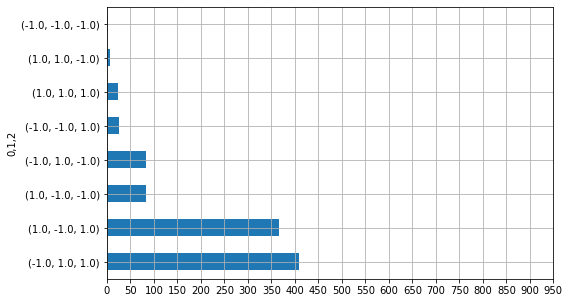

In [ ]:
new_data = []
for i in range(1000):
  new_data.append(boltz.generate_sample())
df = pd.DataFrame(new_data)
print(df.value_counts().plot.barh(figsize=(8,5),grid = True,xticks = np.arange(0, 1000, step=50)))

Risultati per la rete completamente connessa (1000 campioni generati)

AxesSubplot(0.125,0.125;0.775x0.755)


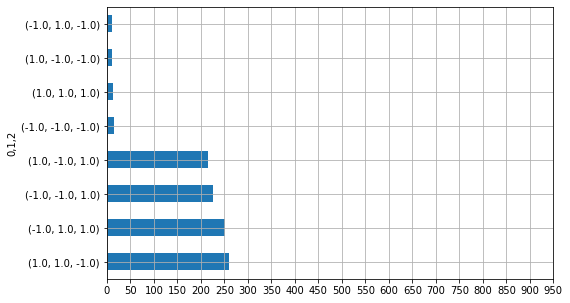

In [ ]:
new_data2 = []
for i in range(1000):
  new_data2.append(boltz.generate_true_sample())
df2 = pd.DataFrame(new_data2)
print(df2.value_counts().plot.barh(figsize=(8,5),grid = True,xticks = np.arange(0, 1000, step=50)))

Performances della rete quando si fornisce il layer di input (1000 predizioni)

AxesSubplot(0.125,0.125;0.775x0.755)


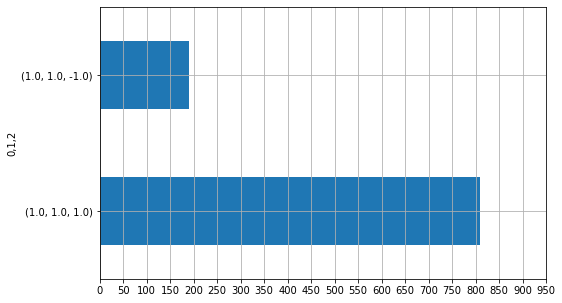

In [ ]:
net_input = [1,1]

new_data3 = []
for i in range(1000):
  new_data3.append(boltz.predict(net_input))
df3 = pd.DataFrame(new_data3)
print(df3.value_counts().plot.barh(figsize=(8,5),grid = True,xticks = np.arange(0, 1000, step=50)))

Performances di predizione per la rete completamente connessa(1000 predizioni)

AxesSubplot(0.125,0.125;0.775x0.755)


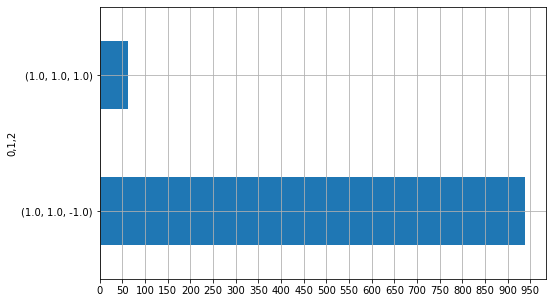

In [ ]:
net_input = [1,1]

new_data4 = []
for i in range(1000):
  new_data4.append(boltz.true_predict(net_input))
df4 = pd.DataFrame(new_data4)
print(df4.value_counts().plot.barh(figsize=(8,5),grid = True,xticks = np.arange(0, 1000, step=50)))